In [1]:
import tensorflow as tf

In [2]:
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd

In [3]:
import numpy as np

In [4]:
print('tf version:', tf.__version__, '\nGPU avilable?:', tf.config.list_physical_devices('GPU'))
print('rdkit version: ', rdkit.__version__)
print('DeepChem version', dc.__version__)

tf version: 2.3.0 
GPU avilable?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
rdkit version:  2020.09.1
DeepChem version 2.4.0-rc1.dev


In [39]:
from feat.simple_mol_graph_conv_featurizer import SimpleMolGraphConvFeaturizer

In [40]:
data = pd.read_csv('./data/QM9_HAC_5_9_.csv')

In [58]:
reduced_data = list(data['SMILES'])
import random
random.shuffle(reduced_data)

In [62]:
len(reduced_data)

133837

In [63]:
mols = list(filter(lambda x: x is not None, [Chem.MolFromSmiles(x) for x in reduced_data]))
len(mols)

132432

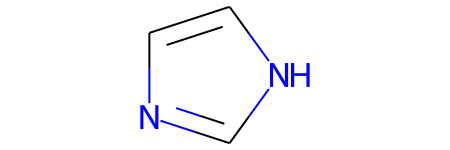

In [65]:
mol = mols[2]
mol

In [11]:
from deepchem.feat.graph_data import GraphData
from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol

bond_labels = [
    Chem.rdchem.BondType.ZERO
    ,Chem.rdchem.BondType.SINGLE
    ,Chem.rdchem.BondType.DOUBLE
    ,Chem.rdchem.BondType.TRIPLE
    ,Chem.rdchem.BondType.AROMATIC]
bond_encoder = {l: i for i, l in enumerate(bond_labels)}
bond_decoder = {i: l for i, l in enumerate(bond_labels)}

atom_labels = [0, 1, 6, 8, 7, 16, 15, 9, 17] #H,C, O, N, S, P, F, Cl
atom_encoder = {l: i for i, l in enumerate(atom_labels)}
atom_decoder = {i: l for i, l in enumerate(atom_labels)}

def _bond_features(mol):
    bonds = []
    for b in mol.GetBonds():
        try:
            bonds += [bond_encoder[b.GetBondType()]]
        except Exception as e:
            raise ValueError('Unsupported bond type detected', e.args[0])
    # depth is equal to encoding lenght == number of bond types
    a = tf.one_hot(bonds, depth=5, dtype=tf.float32)
    #convert to np.ndarray to comply with GraphData object structure
    proto_tensor = tf.make_tensor_proto(a)
    return tf.make_ndarray(proto_tensor)

def _atom_features(mol):
    try:
        atoms = [atom_encoder[atom.GetAtomicNum()] for atom in mol.GetAtoms()]
        print(atoms)
    except Exception as e:
        raise ValueError('Unsupported atom type detected', e.args[0])  
    # depth is equal to encoding lenght == number of atom types
    a = tf.one_hot(atoms, depth=9, dtype=tf.float32)
    #convert to np.ndarray to comply with GraphData object structure
    proto_tensor = tf.make_tensor_proto(a)
    return tf.make_ndarray(proto_tensor)

def _bond_indices(mol):
    src, dest = [], []
    for bond in mol.GetBonds():
        # add edge list considering a directed graph
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        src += [start]
        dest += [end]
    return np.asarray([src, dest], dtype=np.int)

def SimpleGraphDataFeaturizer(mol:RDKitMol, kekulize:bool = True) -> GraphData:
    #needs to be done otherwise going back from graph to molecule will not work for compounds like pyrrole
    if kekulize:
        Chem.Kekulize(mol)
    return GraphData(node_features=_atom_features(mol), edge_index=_bond_indices(mol), edge_features=_bond_features(mol))

def SimpleGraphDataDefeaturizer(graph_data : GraphData, sanitize:bool = True) -> RDKitMol:
    node_features = graph_data.node_features
    bond_features = graph_data.edge_features
    bond_indices = graph_data.edge_index
    
    mol = Chem.RWMol()
    for feature in node_features:
        code = np.argmax(feature, axis=0)
        mol.AddAtom(Chem.Atom(atom_decoder[code]))
    
    #to get start and end of the bond
    bond_indices = np.transpose(bond_indices)
    #to get index from one-hot representation
    bond_features = np.argmax(bond_features, axis=1)

    for bond in zip(bond_indices, bond_features):
        bond_position = bond[0]
        bond_type = bond[1]
        mol.AddBond(int(bond_position[0]), int(bond_position[1]), bond_decoder[bond_type])
        
    if sanitize:
        try:
            Chem.SanitizeMol(mol)
        except:
            return None
    return mol


class GraphMatrix():
    """
    Parameters
    ----------
    node_features: np.ndarray
      Node feature matrix with shape [num_nodes, num_node_features]
    edge_features: np.ndarray,
      Edge feature matrix with shape [num_nodes, num_nodes]
    """
    def __init__(self,node_features: np.ndarray, edge_features: np.ndarray):
        self.node_features = node_features
        self.edge_features = edge_features

        

def SimpleGraphMatrixFeaturizer(mol: RDKitMol) -> GraphMatrix:
        Chem.Kekulize(mol)
        length = len(mol.GetAtoms())
        A = np.zeros(shape=(length, length), dtype=np.float32)
        bonds = mol.GetBonds()

        begin, end = [b.GetBeginAtomIdx() for b in bonds], [b.GetEndAtomIdx() for b in bonds]
        bond_type = [bond_encoder[b.GetBondType()] for b in bonds]

        A[begin, end] = bond_type
        A[end, begin] = bond_type

        degree = np.sum(A[:mol.GetNumAtoms(), :mol.GetNumAtoms()], axis=-1)

        X = np.array([atom_encoder[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=np.int32)
        X = tf.one_hot(X, depth = 9, dtype=tf.float32)
        proto_tensor = tf.make_tensor_proto(X)
        X = tf.make_ndarray(proto_tensor)
        
        gm = GraphMatrix(X,A)
    
        return gm if (degree > 0).all() else None
    
def SimpleGraphMatrixDefeaturizer(graph_matrix: GraphMatrix) -> RDKitMol:
    node_labels = graph_matrix.node_features
    edge_labels = graph_matrix.edge_features
    
    mol = Chem.RWMol()
    
    for node_label in node_labels:
        mol.AddAtom(Chem.Atom(atom_decoder[np.argmax(node_label)]))

    for start, end in zip(*np.nonzero(edge_labels)):
        if start > end:
            mol.AddBond(int(start), int(end), bond_decoder[edge_labels[start, end]])

    try:
        Chem.SanitizeMol(mol)
    except:
        mol = None

    return mol




In [12]:
m = SimpleGraphMatrixFeaturizer(mol)

In [13]:
m.edge_features

array([[0., 1., 0., 0., 1.],
       [1., 0., 2., 0., 0.],
       [0., 2., 0., 1., 0.],
       [0., 0., 1., 0., 2.],
       [1., 0., 0., 2., 0.]], dtype=float32)

In [14]:
m.node_features

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
mol2 = SimpleGraphMatrixDefeaturizer(m)

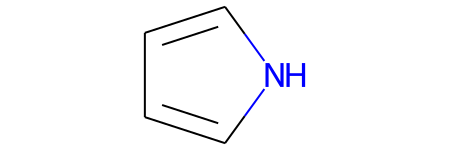

In [16]:
mol2

In [66]:
wf = dc.feat.WeaveFeaturizer()

In [67]:
wm = wf.featurize(mols)

In [71]:
print(wm[1].get_num_atoms())

5


In [69]:
len(mols[1000].GetAtoms())

7